In [5]:
!ls /veld/input/

41.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


logs  summary.yaml


In [227]:
import os
import yaml
import plotly.graph_objects as go
import pandas as pd

In [7]:
IN_EVALUATION_SUMMARY_FILE = "/veld/input/" + os.getenv("in_evaluation_summary_file")

In [8]:
print(f"IN_EVALUATION_SUMMARY_FILE: {IN_EVALUATION_SUMMARY_FILE}")

IN_EVALUATION_SUMMARY_FILE: /veld/input/summary.yaml


In [9]:
with open(IN_EVALUATION_SUMMARY_FILE, "r") as file_in:
    eval_summary = yaml.safe_load(file_in)

In [43]:
eval_summary

{'fasttext': {'m1': {'eval_gold_data': 'eval_data_lowercase.yaml',
   'model_details': {'training_description': 'test training',
    'train_data_description': '10% sample of german wikipedia, single txt, one sentence per line, lowercased, removed punctuation',
    'train_data_size': '685M',
    'train_data_md5_hash': '9683602ee186844125ed90eff1fb2dff',
    'training_epochs': 10,
    'training_vector_size': 200,
    'training_duration (minutes)': 37.0,
    'model_data_size': '2.4G'},
   'score': {'synonyms': 0.03999999910593033,
    'homonyms': 0.09000000357627869,
    'antonyms': -0.03999999910593033}},
  'm2': {'eval_gold_data': 'eval_data_lowercase.yaml',
   'model_details': {'training_description': 'test training',
    'train_data_description': '10% sample of german wikipedia, single txt, one sentence per line, lowercased, removed punctuation',
    'train_data_size': '685M',
    'train_data_md5_hash': '9683602ee186844125ed90eff1fb2dff',
    'training_epochs': 100,
    'training_vect

In [310]:
def normalize_size(size_str):
    if size_str.endswith("G"):
        return float(size_str[:-1])
    elif size_str.endswith("M"):
        return float(size_str[:-1]) / 1000
    else:
        raise Exception

def normalize_epochs(model_id_details_dict):
    if "training_epochs" in model_id_details_dict:
        return int(model_id_details_dict["training_epochs"])
    elif "max_iter" in model_id_details_dict:
        return int(model_id_details_dict["max_iter"])
    else:
        raise Exception

def normalize_vectors(model_id_details_dict):
    if "vector_size" in model_id_details_dict:
        return int(model_id_details_dict["vector_size"])
    elif "training_vector_size" in model_id_details_dict:
        return int(model_id_details_dict["training_vector_size"])
    else:
        raise Exception

def normalize_min_count(model_id_details_dict):
    if "vocab_min_count" in model_id_details_dict:
        return int(model_id_details_dict["vocab_min_count"])
    elif "min_count" in model_id_details_dict:
        return int(model_id_details_dict["min_count"])
    else:
        return -1
    

df = pd.DataFrame()
for model_arch, model_arch_dict in eval_summary.items():
    model_arch_noramlized = model_arch[:1]
    for model_id, model_id_dict in model_arch_dict.items():
        model_id_details_dict = model_id_dict["model_details"]
        model_id_score_dict = model_id_dict["score"]
        df_tmp = pd.DataFrame(
            {
                "model id": [model_arch_noramlized + model_id[-1]],
                "score synonyms": [model_id_score_dict["synonyms"]],
                "score homonyms": [model_id_score_dict["homonyms"]],
                "score antonyms": [model_id_score_dict["antonyms"]],
                "vector size": normalize_vectors(model_id_details_dict),
                "min word count": normalize_min_count(model_id_details_dict),
                "training epochs": normalize_epochs(model_id_details_dict),
                "training duration (hours)": int(model_id_details_dict["training_duration (minutes)"] / 60),
                "model data size (GB)": [normalize_size(model_id_details_dict["model_data_size"])],
                "train data size (GB)": [normalize_size(model_id_details_dict["train_data_size"])],
                "train data hash": model_id_details_dict["train_data_md5_hash"][:8],
            }
        )
        df = pd.concat([df, df_tmp], ignore_index=True)
df

,model id,score synonyms,score homonyms,score antonyms,vector size,min word count,training epochs,training duration (hours),model data size (GB),train data size (GB),train data hash
0,f1,0.04,0.09,-0.04,200,-1,10,0,2.400,0.685,9683602e
1,f2,0.06,0.10,-0.06,200,-1,100,6,2.400,0.685,9683602e
2,w1,0.09,0.05,-0.08,200,5,10,0,0.019,0.685,9683602e
3,w2,0.08,0.04,-0.07,200,5,100,3,0.019,0.685,9683602e
4,g1,0.06,0.04,-0.10,200,5,10,0,16.000,0.679,09bd7f10
5,g2,0.07,0.01,-0.12,200,5,100,6,16.000,0.679,09bd7f10


In [308]:
def create_axis(df, col_name):

    # check if this column has any non-numeric value
    is_numeric = True
    for row in df.iterrows():
        row_list = row[1].to_list()
        try:
            round(row_list[1], 3)
        except:
            is_numeric = False
            break

    # iterate over rows and create potentially compressed value-label pairs
    value_list = []
    ticks_dict = {}
    non_numeric_dict = {}
    for row in df.iterrows():

        # get label and value from row
        row_list = row[1].to_list()
        label = row_list[0]
        value = row_list[1]
        try:
            value = round(value, 3)
        except:
            pass

        # merge labels if values already occurred before
        label_pre = ticks_dict.get(value)
        if label_pre is not None:
            label = label_pre + "," + label
        ticks_dict[value] = label

        # handle non-numeric values, by creating fake numeric values
        if is_numeric:
            value_list.append(value)
        else:
            fake_value = non_numeric_dict.get(value)
            if fake_value is None:
                fake_value = len(non_numeric_dict) + 1
            non_numeric_dict[value] = fake_value
            value_list.append(fake_value)

    # create main label and value data structure for plotly's tick attributes
    tick_label_list = []
    tick_value_list = []
    for value, label in ticks_dict.items():
        tick_label_list.append(label + ": " + str(value))
        if is_numeric:
            tick_value_list.append(value)
        else:
            tick_value_list.append(non_numeric_dict[value])
        
    return {
        "tickvals": tick_value_list,
        "ticktext": tick_label_list,
        "label": col_name,
        "values": value_list,
    }

def create_dimensions(df):
    dim_list = []
    for col_name in df:
        if col_name != "model id":
            dim_list.append(create_axis(df[["model id", col_name]], col_name))
    return dim_list
    
dim_list = create_dimensions(df)

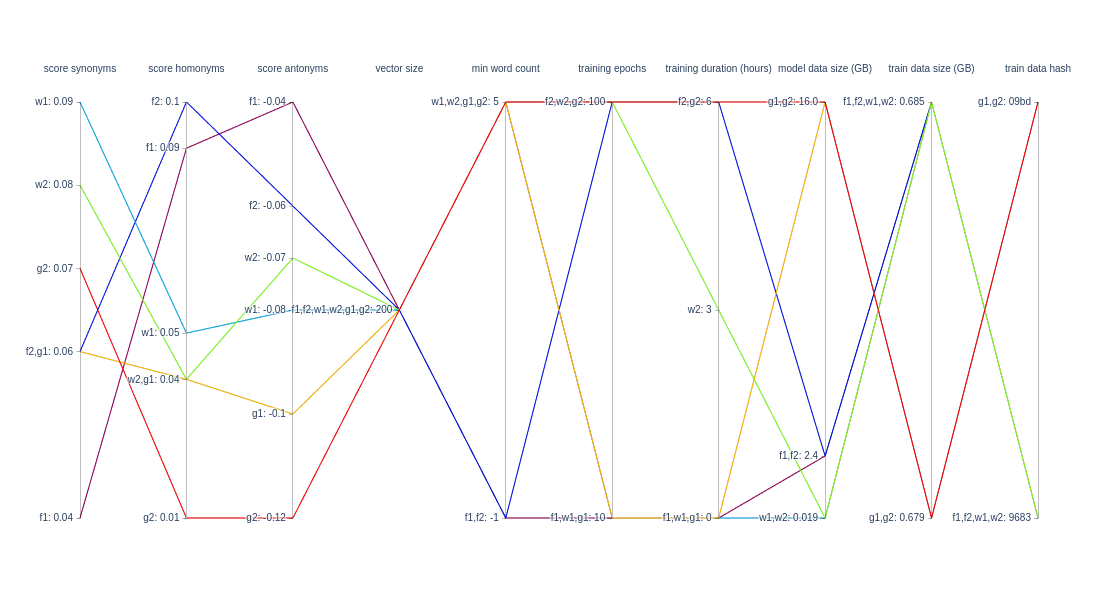

In [311]:
fig = go.Figure(
    data=go.Parcoords(
        line={"color": list(df.index), "colorscale": 'Rainbow'},
        dimensions=dim_list
    )
)
fig.update_layout(height=600)
fig.show()